<a href="https://colab.research.google.com/github/kimalpaca/Advanced-Graphics-Programming/blob/master/Double_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!apt-get update
!apt-get install xvfb
!apt-get install python3-tk
!pip install numpy==1.23.5
!pip install tk
!pip install gym[box2d]
!pip install gym-notebook-wrapper
!export MPLBACKEND=TKAg

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [15]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import gnwrapper


import time

In [16]:
import torch
import torch.nn as nn

In [17]:
env = gym.envs.make("Acrobot-v1")

In [18]:
def plot_res(values, title=''):
    clear_output(wait=True)
    # 양수 점수로 변환
    scores = [500 + v for v in values]  # ✅ 핵심 변화
    x = range(len(scores))
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title)

    # 학습 곡선
    ax[0].plot(x, scores, label='score per run')
    ax[0].axhline(400, c='red', ls='--', label='success zone')  # ✅ 기준선
    try:
        z = np.polyfit(x, scores, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), '--', color='orange')
    except:
        pass
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Score (higher is better)')
    ax[0].legend()

    # 히스토그램
    ax[1].hist(scores[-500:])
    ax[1].axvline(400, c='red', label='success zone')
    ax[1].set_xlabel('Scores per Last 500 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()

    plt.show()


In [19]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [20]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)

    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))

    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())

    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

In [27]:
def q_learning(env, model, episodes, gamma=0.99,
               epsilon=1.0, eps_decay=0.995,
               replay=False, replay_size=64,
               title='DQL', double=False,
               n_update=10, soft=False, verbose=True):
    final = []
    memory = []
    episode_i = 0
    sum_total_replay_time = 0
    best_score = -1

    for episode in range(episodes):
        episode_i += 1
        if double and not soft:
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()

        state = env.reset()
        done = False
        total = 0
        step = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            total += reward
            memory.append((state, action, next_state, reward, done))

            if done:
                if not replay:
                    q_values = model.predict(state).tolist()[0]
                    q_values[action] = reward
                    model.update(state, q_values)
                break

            if replay and step % 5 == 0:  # ✅ 5스텝마다 replay로 속도 개선
                t0 = time.time()
                model.replay(memory, replay_size, gamma)
                t1 = time.time()
                sum_total_replay_time += (t1 - t0)
            elif not replay:
                q_values = model.predict(state).tolist()[0]
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
            step += 1

        epsilon = max(epsilon * eps_decay, 0.05)
        final.append(total)

        score = 500 + total  # ✅ 양수 점수화
        if score > best_score:
            best_score = score

        plot_res(final, title)

        if verbose:
            print(f"ep: {episode_i:4d} | score: {int(score):4d} | best: {int(best_score):4d}")
            if replay:
                print(f"Average replay time: {sum_total_replay_time / episode_i:.4f} sec")

    return final


In [28]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

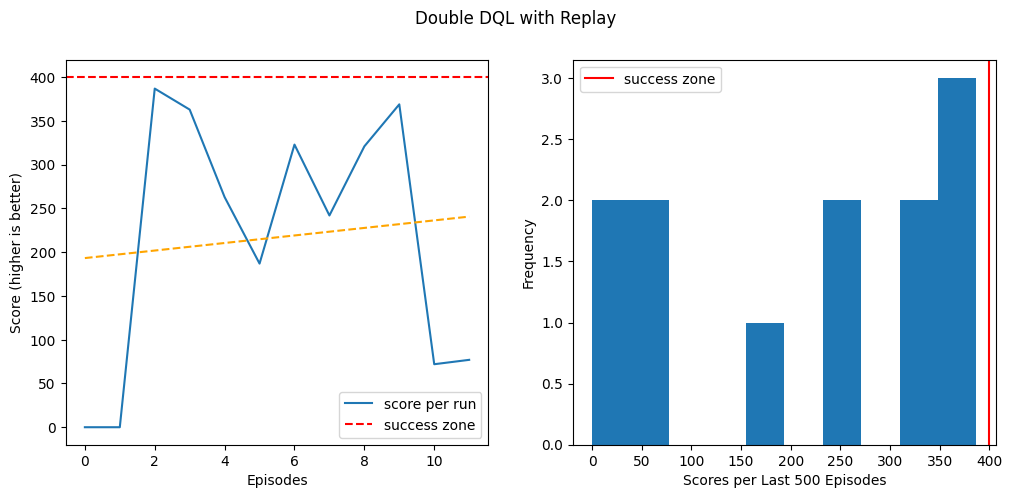

ep:   12 | score:   77 | best:  387
Average replay time: 0.8384 sec


In [ ]:
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9,
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)

In [ ]:
env_ani = gnwrapper.Monitor(gym.make("Acrobot-v1", render_mode="single_rgb_array"))
observation = env_ani.reset(seed=1000)

for t in range(500):
    qs = dqn_double.predict(observation)
    action = torch.argmax(qs).item()
    observation, reward, done, _ = env_ani.step(action)
    if done:
        print(f"종료 at step {t}")
        break

env_ani.display()


NameError: name 'gnwrapper' is not defined